# Evaluating performance

Analysis by [Laurent Lessard](https://laurentlessard.com/) and [Vincent Tjeng](https://vtjeng.com).

This file applies the strategy from `wordle_solver.ipynb` to all possible words and creates histograms to show the results. 

For efficiency, `performance.ipynb` pre-computes and cache all possible measurements of word pairs (via `cache_word_scores`) and works with the indices of the words in the `ALL_WORDS` list, rather than the words themselves. This improves efficiency significantly as we run the strategy repeatedly on all words in the dictionary.

In [1]:
# for prop, freqtable
using FreqTables
include("utils.jl");

In [2]:
cache_word_scores(ALL_WORDS, SOLUTION_WORDS)

 11.968786 seconds (171.57 M allocations: 14.139 GiB, 7.69% gc time, 0.03% compilation time)


## Helper Functions

In [4]:
function get_display_text(heuristic::Heuristic)::String
    if heuristic == PRIORITIZE_MAX_GROUP_SIZE
        return "size"
    elseif heuristic == PRIORITIZE_ENTROPY
        return "entropy"
    elseif heuristic == PRIORITIZE_SPLITS
        return "splits"
    end
    throw(ArgumentError("Unexpected heuristic."))
end


function word_stats(
    starting_word::Int;
    guess_all_words::Bool = false,
    heuristic::Heuristic = PRIORITIZE_ENTROPY,
    hard_mode::Bool = false,
)
    num_turns = get_num_turns(
        guess_all_words ? ALL_WORD_IDXS : SOLUTION_WORD_IDXS,
        SOLUTION_WORD_IDXS,
        heuristic = heuristic,
        hard_mode = hard_mode,
        starting_word = starting_word
    )
    return [prop(freqtable(num_turns)), Statistics.mean(num_turns), maximum(num_turns)]
end

function generate_stats(;
    guess_all_words::Bool = false,
    hard_mode::Bool = false,
    heuristic::Heuristic = PRIORITIZE_ENTROPY,
    max_val::Int = 0
)
    num_turns = get_num_turns(
        guess_all_words ? ALL_WORD_IDXS : SOLUTION_WORD_IDXS,
        SOLUTION_WORD_IDXS,
        heuristic = heuristic,
        hard_mode = hard_mode,
        verbose = true
    )

    heuristic_text = get_display_text(heuristic)
    fn_1 = hard_mode ? "hard_mode_" : ""
    fn_2 = guess_all_words ? "any_guess_" : "solutions_only_"
    tt_1 = hard_mode ? "hard mode, " : ""
    tt_2 = guess_all_words ? "any guess allowed " : "only guess from solutions list "
    plot_num_turns(
        num_turns,
        title_text = "$(tt_1)$(tt_2)(max-$(heuristic_text))",
        saved_filename = "strat_using_$(fn_1)$(fn_2)prioritize_$(heuristic_text).png",
        max_val = max_val
    )

    println("\nProportions")
    println(prop(freqtable(num_turns)))

    println("\nMean Score")
    println(Statistics.mean(num_turns))
end;

## Comparison of different starting words (simple strategy)

In [5]:
@time begin
solnstats = [ word_stats( i, heuristic=PRIORITIZE_SPLITS, hard_mode=false, guess_all_words=false ) for i in SOLUTION_WORD_IDXS ]
end;

3931.914005 seconds (86.25 G allocations: 4.153 TiB, 9.40% gc time, 0.05% compilation time)


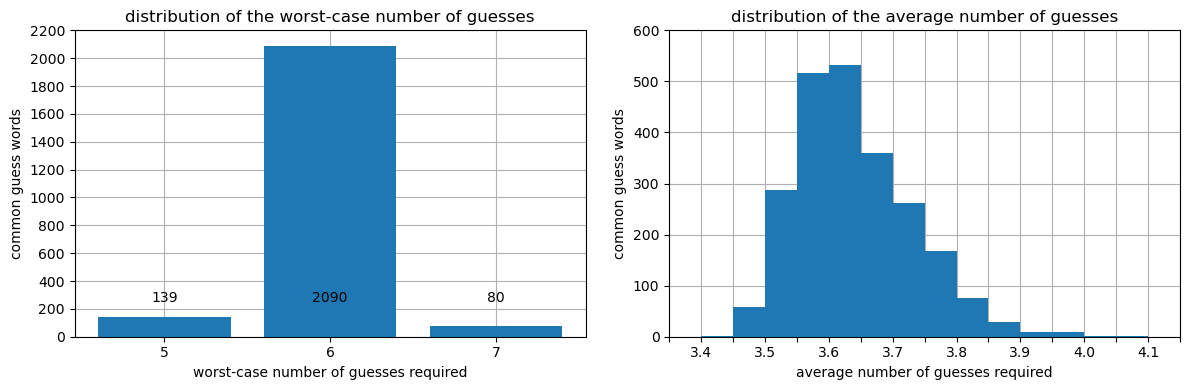

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
["model", "react", "sower", "unmet", "forth", "wooer", "biome", "labor", "world", "group"]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
["tenth", "theft", "mamma", "chess", "magma", "setup", "gummy", "scree", "sully", "snore", "feral"]
[3.447812906019922, 3.4538761368557815, 3.454309224772629, 3.454309224772629, 3.461238631442183]
["slate", "trace", "crate", "crane", "slant", "least", "stale", "trice", "roast", "stare"]


In [7]:
figure(figsize=(12,4))
subplot(1,2,1)
mxs = [solnstats[i][3] for i in SOLUTION_WORD_IDXS]
maxes = countmap(mxs)
k = collect(keys(maxes))
v = collect(values(maxes))
bar( k,v, zorder=2  )
xticks(k)
yticks(0:200:2200)
xlabel("worst-case number of guesses required")
ylabel("common guess words")
title("distribution of the worst-case number of guesses")
grid(zorder=1)
for i in 1:length(k)
    text(k[i],250, v[i], horizontalalignment = "center")
end

ix = sortperm(mxs)
mm = 10
println(mxs[ix[1:mm]])
println(SOLUTION_WORDS[ix[1:mm]])
println(mxs[ix[end-mm:end]])
println(SOLUTION_WORDS[ix[end-mm:end]])

subplot(1,2,2)
avgs = [solnstats[i][2] for i in SOLUTION_WORD_IDXS]
hist( avgs, bins=3.35:0.05:4.15, zorder=2 );
grid(zorder=1)
xlabel("average number of guesses required")
ylabel("common guess words")
title("distribution of the average number of guesses")
xticks(3.35:0.05:4.15, ["",3.4,"",3.5,"",3.6,"",3.7,"",3.8,"",3.9,"",4.0,"",4.1,""])
xlim([3.35,4.15])
ylim([0,600])

ix = sortperm(avgs)
println(avgs[ix[1:5]])
println(SOLUTION_WORDS[ix[1:10]])

tight_layout(w_pad=2)
savefig("figures/common_word_strat_comparison.png", dpi=400);

In [8]:
@time begin
solnstats_hard = [ word_stats( i, heuristic=PRIORITIZE_SPLITS, hard_mode=true, guess_all_words=false ) for i in SOLUTION_WORD_IDXS ]
end;

215.765561 seconds (4.85 G allocations: 162.361 GiB, 7.62% gc time, 0.01% compilation time)


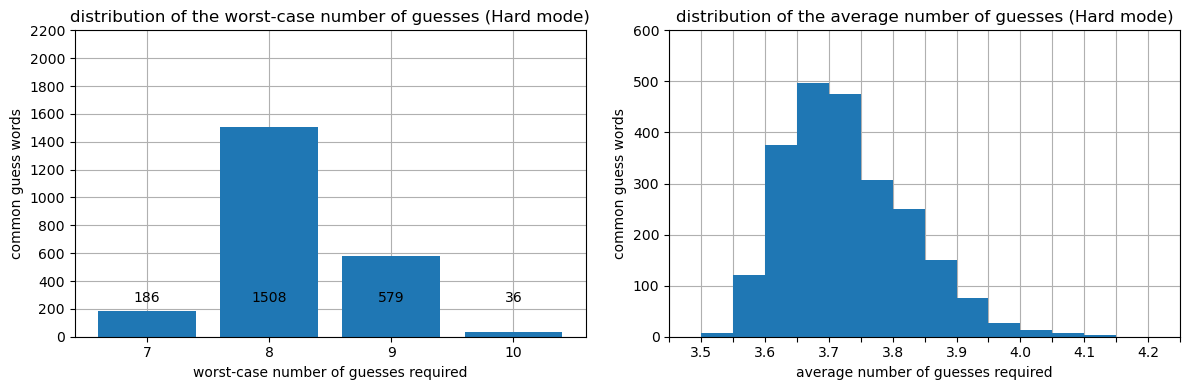

[7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
["humph", "focal", "crust", "whelp", "trawl", "belly", "salad", "spray", "spend", "thumb"]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
["token", "ankle", "ladle", "ditch", "angel", "coven", "liken", "yacht", "clone", "bigot", "judge"]
[3.527934170636639, 3.533564313555652, 3.534430489389346, 3.542226071892594, 3.54439151147683]
["slate", "trace", "least", "crate", "crane", "slant", "stale", "leant", "train", "trice"]


In [9]:
figure(figsize=(12,4))
subplot(1,2,1)
mxs = [solnstats_hard[i][3] for i in SOLUTION_WORD_IDXS]
maxes = countmap(mxs)
k = collect(keys(maxes))
v = collect(values(maxes))
bar( k,v, zorder=2  )
xticks(k)
yticks(0:200:2200)
xlabel("worst-case number of guesses required")
ylabel("common guess words")
title("distribution of the worst-case number of guesses (Hard mode)")
grid(zorder=1)
for i in 1:length(k)
    text(k[i],250, v[i], horizontalalignment = "center")
end

ix = sortperm(mxs)
mm = 10
println(mxs[ix[1:mm]])
println(SOLUTION_WORDS[ix[1:mm]])
println(mxs[ix[end-mm:end]])
println(SOLUTION_WORDS[ix[end-mm:end]])

subplot(1,2,2)
avgs = [solnstats_hard[i][2] for i in SOLUTION_WORD_IDXS]
hist( avgs, bins=3.35:0.05:4.15, zorder=2 );
grid(zorder=1)
xlabel("average number of guesses required")
ylabel("common guess words")
title("distribution of the average number of guesses (Hard mode)")
xticks(3.45:0.05:4.25, ["",3.5,"",3.6,"",3.7,"",3.8,"",3.9,"",4.0,"",4.1,"",4.2,""])
xlim([3.45,4.25])
ylim([0,600])

ix = sortperm(avgs)
println(avgs[ix[1:5]])
println(SOLUTION_WORDS[ix[1:10]])

tight_layout(w_pad=2)
savefig("figures/common_word_strat_comparison_hard.png", dpi=400)

---

## Additional plots for blog post

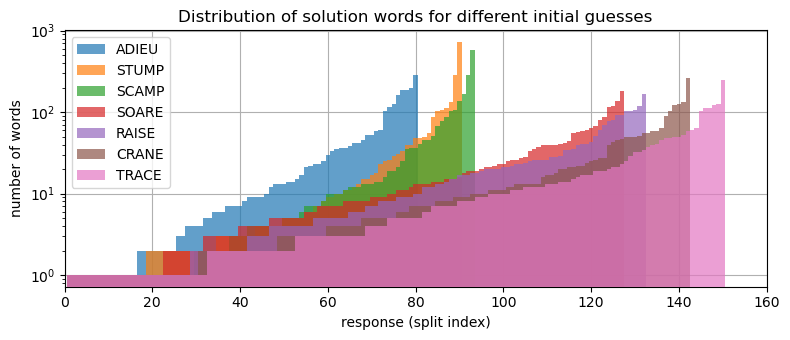

In [5]:
figure(figsize=(8,3.5))
wlist = ["adieu", "stump", "scamp", "soare", "raise", "crane", "trace"]
for w in wlist
    g = sort!(get_group_sizes(w,SOLUTION_WORDS))
    bar(1:length(g), g, label=uppercase(w), width=1, alpha=0.7, zorder=4, log=true)
end
xlim([0,160])
xlabel("response (split index)")
ylabel("number of words")
grid(zorder=2)
legend()
title("Distribution of solution words for different initial guesses")
tight_layout()
savefig("figures/word_pdf.png", dpi=600)

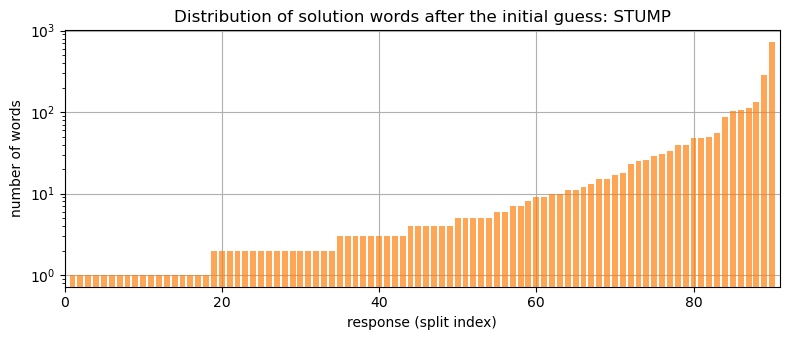

In [6]:
figure(figsize=(8,3.5))
wlist = ["stump"]
for w in wlist
    g = sort!(get_group_sizes(w,SOLUTION_WORDS))
    bar(1:length(g), g, color="C1", label=uppercase(w), width=0.75, alpha=0.7, zorder=4, log=true)
end
xlim([0,91])
xlabel("response (split index)")
ylabel("number of words")
grid(zorder=2)
title("Distribution of solution words after the initial guess: STUMP")
# legend(loc="upper right")
tight_layout()
savefig("figures/word_pdf_stump_new.png", dpi=600)

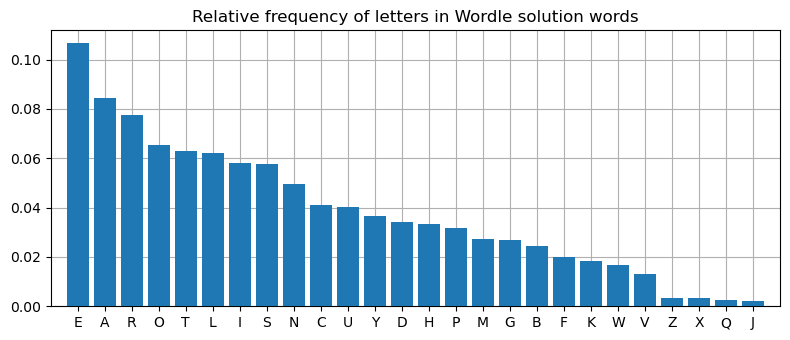

In [7]:
x = countmap(split(uppercase(join(SOLUTION_WORDS)),""))
k = collect(keys(x))
v = collect(values(x)) / length(join(SOLUTION_WORDS))
I = sortperm(v, rev=true)

figure(figsize=(8,3.5))
bar(1:26,v[I],tick_label=k[I],zorder=4)
grid(zorder=2)
xlim([0,27])
title("Relative frequency of letters in Wordle solution words")
tight_layout()
savefig("figures/lett_freq.png", dpi=600)

---

## Results

### Using only solution words as guesses, prioritizing entropy

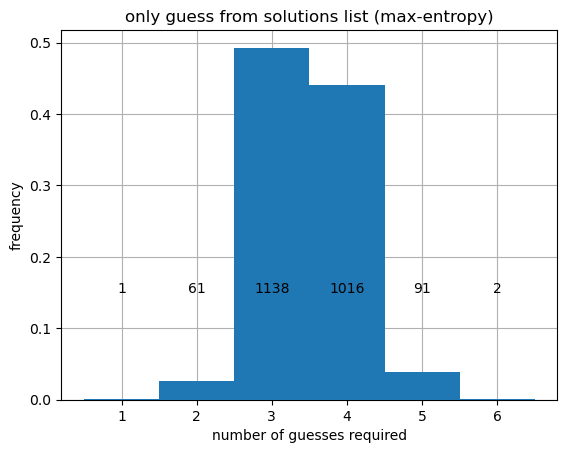

Guess: raise

Proportions
6-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
1     │ 0.000433088
2     │   0.0264184
3     │    0.492854
4     │    0.440017
5     │    0.039411
6     │ 0.000866176

Mean Score
3.4941533131225637
  4.156640 seconds (54.15 M allocations: 2.522 GiB, 8.70% gc time, 37.99% compilation time)


In [8]:
@time generate_stats(
    guess_all_words = false,
    hard_mode = false,
    heuristic = PRIORITIZE_ENTROPY
)

### Using only solution words as guesses, prioritizing maxsize

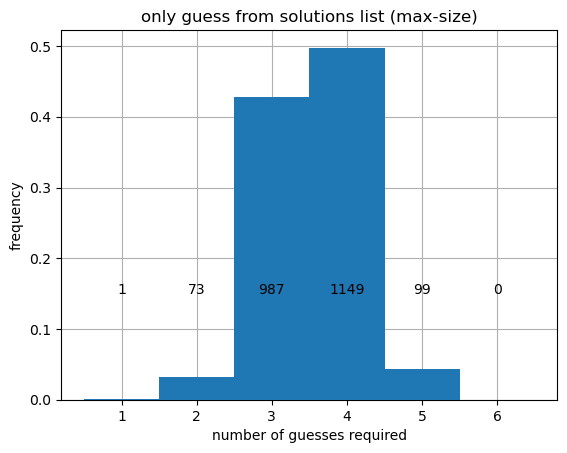

Guess: raise

Proportions
5-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
1     │ 0.000433088
2     │   0.0316154
3     │    0.427458
4     │    0.497618
5     │   0.0428757

Mean Score
3.5508878302295366
  2.646790 seconds (51.62 M allocations: 2.383 GiB, 15.19% gc time, 0.10% compilation time)


In [10]:
@time generate_stats(
    guess_all_words = false,
    hard_mode = false,
    heuristic = PRIORITIZE_MAX_GROUP_SIZE,
    max_val = 6
)

### Using only solution words as guesses, prioritizing max splits

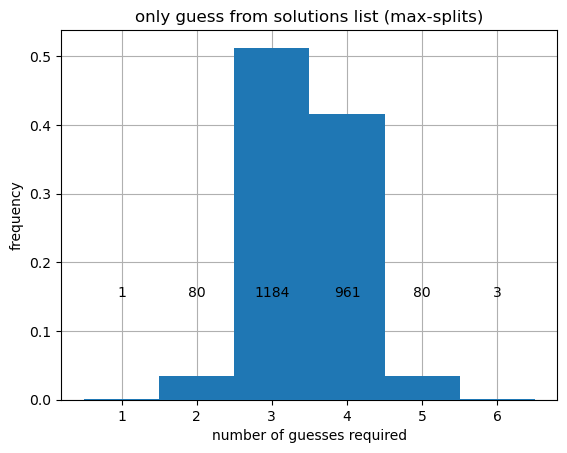

Guess: trace

Proportions
6-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
1     │ 0.000433088
2     │    0.034647
3     │    0.512776
4     │    0.416197
5     │    0.034647
6     │  0.00129926

Mean Score
3.4538761368557815
  2.304650 seconds (48.98 M allocations: 2.257 GiB, 9.20% gc time)


In [11]:
@time generate_stats(
    guess_all_words = false,
    hard_mode = false,
    heuristic = PRIORITIZE_SPLITS
)

### Using all possible words as guesses, prioritizing entropy

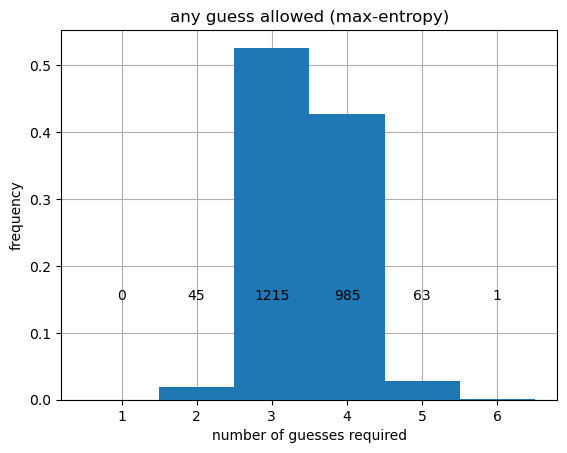

Guess: soare

Proportions
5-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
2     │    0.019489
3     │    0.526202
4     │    0.426592
5     │   0.0272845
6     │ 0.000433088

Mean Score
3.4629709831095714
 14.569992 seconds (289.10 M allocations: 12.790 GiB, 11.25% gc time)


In [12]:
@time generate_stats(
    guess_all_words = true,
    hard_mode = false,
    heuristic = PRIORITIZE_ENTROPY
)

### Using all possible words as guesses, prioritizing maxsize

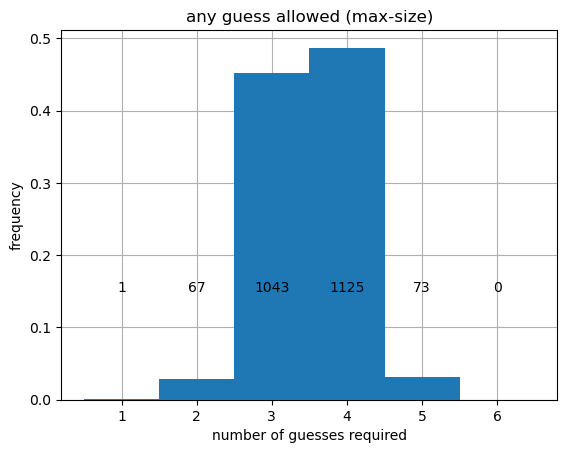

Guess: raise

Proportions
5-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
1     │ 0.000433088
2     │   0.0290169
3     │    0.451711
4     │    0.487224
5     │   0.0316154

Mean Score
3.5205716760502384
 13.628880 seconds (299.39 M allocations: 13.354 GiB, 13.71% gc time)


In [13]:
@time generate_stats(
    guess_all_words = true,
    hard_mode = false,
    heuristic = PRIORITIZE_MAX_GROUP_SIZE,
    max_val = 6
)

### Using all possible words as guesses, prioritizing max splits

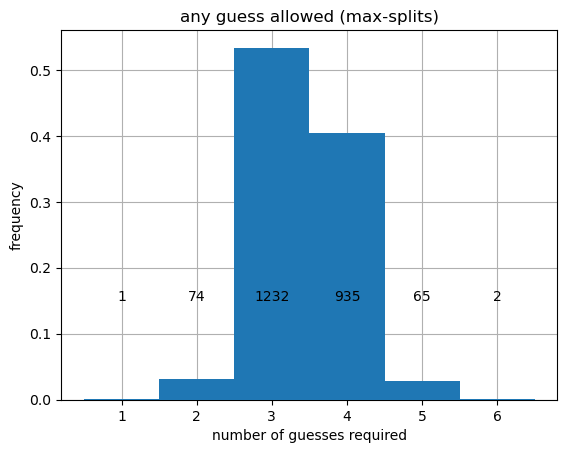

Guess: trace

Proportions
6-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
1     │ 0.000433088
2     │   0.0320485
3     │    0.533564
4     │    0.404937
5     │   0.0281507
6     │ 0.000866176

Mean Score
3.4309224772628846
 13.901155 seconds (283.11 M allocations: 12.545 GiB, 11.55% gc time)


In [14]:
@time generate_stats(
    guess_all_words = true,
    hard_mode = false,
    heuristic = PRIORITIZE_SPLITS
)

### Using only solutions words as guesses + hard mode, prioritizing entropy

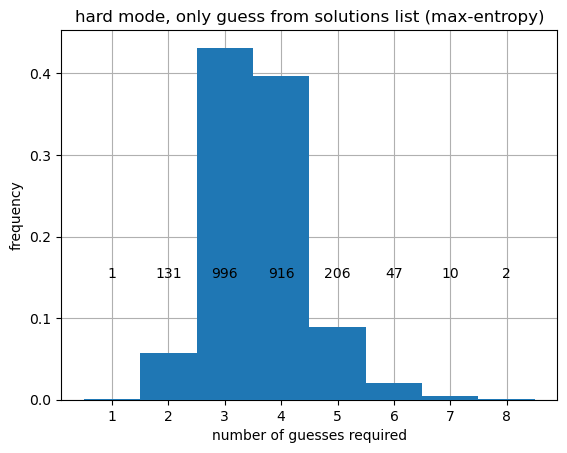

Guess: raise

Proportions
8-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
1     │ 0.000433088
2     │   0.0567345
3     │    0.431356
4     │    0.396709
5     │   0.0892161
6     │   0.0203551
7     │  0.00433088
8     │ 0.000866176

Mean Score
3.600259852750108
  0.910045 seconds (15.63 M allocations: 564.558 MiB, 8.70% gc time, 9.08% compilation time)


In [15]:
@time generate_stats(
    guess_all_words = false,
    hard_mode = true,
    heuristic = PRIORITIZE_ENTROPY
)

### Using only solutions words as guesses + hard mode, prioritizing maxsize

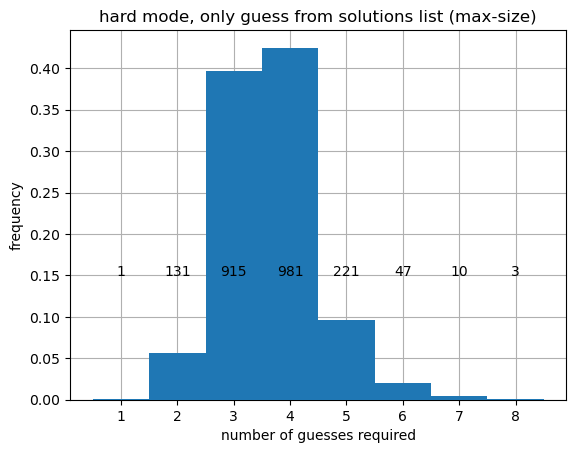

Guess: raise

Proportions
8-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
1     │ 0.000433088
2     │   0.0567345
3     │    0.396275
4     │    0.424859
5     │   0.0957124
6     │   0.0203551
7     │  0.00433088
8     │  0.00129926

Mean Score
3.6435686444348203
  0.840980 seconds (15.35 M allocations: 548.314 MiB, 6.34% gc time)


In [16]:
@time generate_stats(
    guess_all_words = false,
    hard_mode = true,
    heuristic = PRIORITIZE_MAX_GROUP_SIZE
)

### Using only solutions words as guesses + hard mode, prioritizing max splits

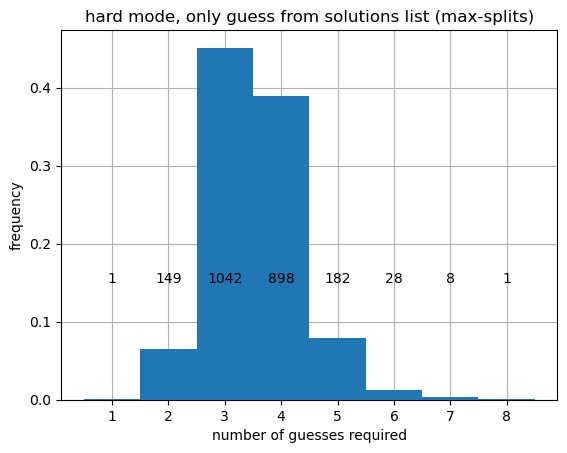

Guess: trace

Proportions
8-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
1     │ 0.000433088
2     │   0.0645301
3     │    0.451278
4     │    0.388913
5     │    0.078822
6     │   0.0121265
7     │   0.0034647
8     │ 0.000433088

Mean Score
3.533564313555652
  0.838640 seconds (15.21 M allocations: 548.569 MiB, 5.90% gc time)


In [17]:
@time generate_stats(
    guess_all_words = false,
    hard_mode = true,
    heuristic = PRIORITIZE_SPLITS
)

### Using all possible words as guesses + hard mode, prioritizing entropy

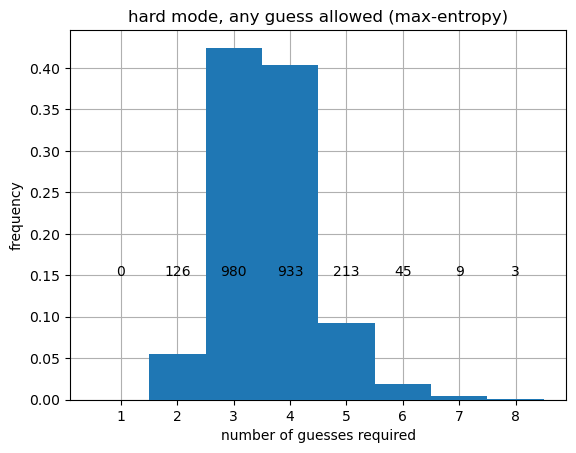

Guess: soare

Proportions
7-element Named Vector{Float64}
Dim1  │ 
──────┼───────────
2     │  0.0545691
3     │   0.424426
4     │   0.404071
5     │  0.0922477
6     │   0.019489
7     │ 0.00389779
8     │ 0.00129926

Mean Score
3.6145517540060634
  4.609753 seconds (96.76 M allocations: 3.220 GiB, 10.60% gc time)


In [18]:
@time generate_stats(
    guess_all_words = true,
    hard_mode = true,
    heuristic = PRIORITIZE_ENTROPY
)

### Using all possible words as guesses + hard mode, prioritizing maxsize

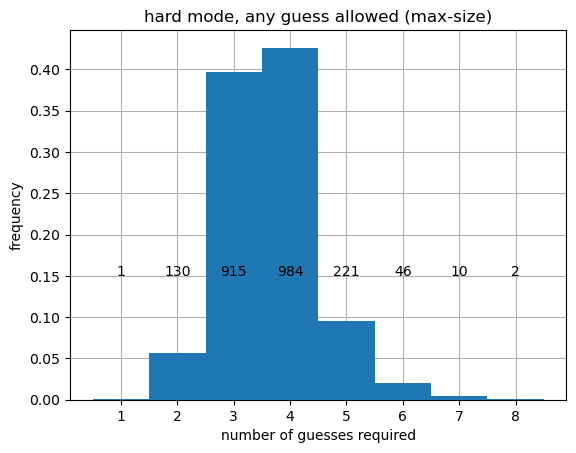

Guess: raise

Proportions
8-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
1     │ 0.000433088
2     │   0.0563014
3     │    0.396275
4     │    0.426159
5     │   0.0957124
6     │    0.019922
7     │  0.00433088
8     │ 0.000866176

Mean Score
3.6418362927674317
  4.874234 seconds (95.84 M allocations: 3.196 GiB, 19.62% gc time)


In [19]:
@time generate_stats(
    guess_all_words = true,
    hard_mode = true,
    heuristic = PRIORITIZE_MAX_GROUP_SIZE
)

### Using all possible words as guesses + hard mode, prioritizing max splits

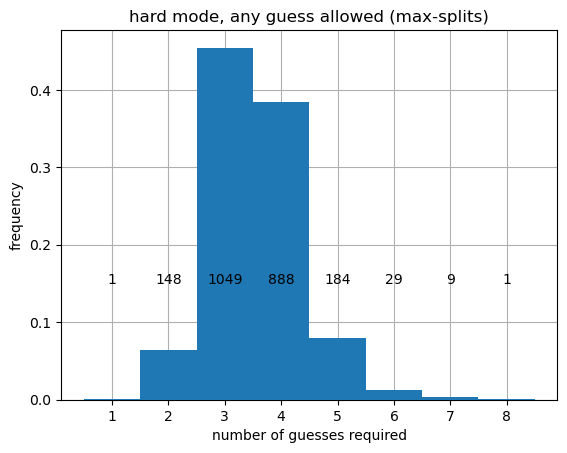

Guess: trace

Proportions
8-element Named Vector{Float64}
Dim1  │ 
──────┼────────────
1     │ 0.000433088
2     │    0.064097
3     │    0.454309
4     │    0.384582
5     │   0.0796882
6     │   0.0125595
7     │  0.00389779
8     │ 0.000433088

Mean Score
3.534430489389346
  4.749509 seconds (97.09 M allocations: 3.256 GiB, 14.03% gc time)


In [20]:
@time generate_stats(
    guess_all_words = true,
    hard_mode = true,
    heuristic = PRIORITIZE_SPLITS
)